# **랭그래프 시작하기**
pip install langgraph

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

## 상태(State)와 노드(Node)
- 상태: 그래프에서 공유되는 데이터(보통 dict)
- 노드: 특정 작업을 수행하는 곳(함수)

In [4]:
from typing_extensions import TypedDict # TypedDict는 딕셔너리의 키의 타입을 정의할 때 사용
from langgraph.graph import StateGraph, START, END

class State(TypedDict): # dict
    counter: int # 첫 번재 키
    strings: list[str] # 두 번째 키

def node_a(state:State):
    state['counter'] += 1
    state['strings'] = ['Hello LangGraph']
    return state

## 엣지(Edge)와 그래프(Graph)
- 엣지: 노드 간의 연결 상태. 다음 작업을 수행할 노드를 결정
- 그래프: 상태, 노드, 엣지를 요소로 그래프 형태로 이루어진 워크플로우

In [6]:
# 그래프 객체 생성
graph_builder = StateGraph(State)

# 노드 만들기
graph_builder.add_node('chatbot', node_a)

# 엣지 만들기
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

# 컴파일
graph = graph_builder.compile()

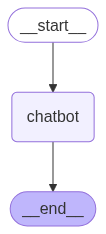

In [7]:
# 그래프 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 그래프 실행

In [8]:
# 초기 상태 정의
state = {
    "counter":0,
    "strings":[]
}

# 그래프를 따라 한 번 작업 수행
state = graph.invoke(state)
print(state)

{'counter': 1, 'strings': ['Hello LangGraph']}


In [9]:
for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 2, 'strings': ['Hello LangGraph']}
{'counter': 3, 'strings': ['Hello LangGraph']}
{'counter': 4, 'strings': ['Hello LangGraph']}


## Reducer
reducer라는 개념은 상태(State)를 여러 번 업데이트할 때, 그 결과들을 어떻게 합칠지를 정의하는 함수를 말합니다.

In [10]:
from typing import Annotated
import operator

class State(TypedDict):
    counter: int 
    strings: Annotated[list[str], operator.add] # 누적해서 더함

def node_a(state:State):
    state['counter'] += 1
    state['strings'] = ['Hello LangGraph']
    return state

graph_builder = StateGraph(State)
graph_builder.add_node('chatbot', node_a)
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)
graph = graph_builder.compile()

initial_state = {
    "counter":0,
    "strings":[]
}

state = initial_state

for _ in range(5):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'strings': ['Hello LangGraph']}
{'counter': 2, 'strings': ['Hello LangGraph', 'Hello LangGraph']}
{'counter': 3, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}
{'counter': 4, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}
{'counter': 5, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}


## 조건 분기: Conditional Edge

In [35]:
def replace_reducer(old: list, new: list) -> list:
    return new

class State(TypedDict):
    counter: int 
    strings: Annotated[list[str], replace_reducer]

def node_a(state:State):
    return {
        'counter': state['counter'] + 1,
        'strings': state['strings'] + ['Hello LangGraph']
    }

def node_b(state:State):
    current_strings = state['strings']
    new_strings = current_strings[:-2] if len(current_strings) >= 2 else []
    return {
        'counter': state['counter'] - 2,
        'strings': new_strings
    }

def decide_next(state: State):
    if state["counter"] > 5:
        return "decrease"
    else:
        return END

graph_builder = StateGraph(State)
graph_builder.add_node('chatbot', node_a)
graph_builder.add_node('decrease', node_b)

graph_builder.add_edge(START, 'chatbot')

graph_builder.add_conditional_edges(
    'chatbot',
    decide_next,
    {"decrease": "decrease", END: END}
)

# graph_builder.add_edge('chatbot', END)
graph_builder.add_edge('decrease', 'chatbot')

graph = graph_builder.compile()

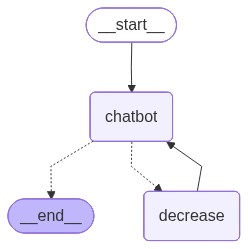

In [36]:
# 그래프 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
initial_state = {
    "counter":0,
    "strings":[]
}

state = initial_state

for _ in range(7):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'strings': ['Hello LangGraph']}
{'counter': 2, 'strings': ['Hello LangGraph', 'Hello LangGraph']}
{'counter': 3, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}
{'counter': 4, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}
{'counter': 5, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}
{'counter': 5, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}
{'counter': 5, 'strings': ['Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph', 'Hello LangGraph']}


## Simple Chatbot

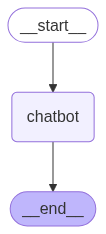

In [38]:
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages

llm = ChatOpenAI(model='gpt-4o-mini')

class State(TypedDict):
    messages: Annotated[list[str], add_messages]

graph_builder = StateGraph(State)

def chatbot(state:State) -> dict:
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
# user input이 있으면 거기에 응답이 추가되지만 매번 입력할 때마다 dict 새로 생성됨. 히스토리 저장 못함.

while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit", "quit", "q"]:
        print("Goodbye!")
        break

    response = graph.invoke({"messages": ("user", user_input)})
    # print(response)
    # print(response["messages"])
    print('==========')
    print('AI: ' + response["messages"][-1].content)

AI: 안녕하세요! 어떻게 도와드릴까요?
AI: 일본의 수도는 도쿄입니다. 도쿄는 일본의 정치, 경제, 문화의 중심지로 알려져 있습니다.
Goodbye!


In [41]:
# MemorySaver를 사용해서 히스토리 저장하기
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)

graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

memory = MemorySaver()

config = {"configurable": {"thread_id": "abcd"}}

graph = graph_builder.compile(checkpointer = memory)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit", "quit", "q"]:
        print("Goodbye!")
        break

    ## (1) invoke mode
    # response = graph.invoke({"messages": ("user", user_input)}, config=config)
    # # print(response)
    # # print(response["messages"])
    # print('==========')
    # print('AI: ' + response["messages"][-1].content)
    
    # (2) stream mode
    print('User\t:', user_input)
    print('==========')
    print('AI\t:')
    for chunk, _ in graph.stream({"messages": ("user", user_input)}, config=config, stream_mode="messages"):
        print(chunk.content, end="")
    print('==========')

User	: 안녕? 나는 이용환이야.
AI	:
안녕하세요, 이용환님! 어떻게 도와드릴까요?

User	: 한국의 수도가 어디야?
AI	:
한국의 수도는 서울입니다. 궁금한 점이 더 있으신가요?

User	: 한국과 일본 관계에 대해 설명해줘.
AI	:
한국과 일본의 관계는 역사적으로 복잡하고 많은 변화를 겪어왔습니다. 주요 포인트를 살펴보면 다음과 같습니다.

1. **역사적 배경**:
   - 일본은 1910년부터 1945년까지 한반도를 식민지로 지배했습니다. 이 시기의 억압과 착취로 인해 양국 간의 감정은 매우 좋지 않았습니다.
   - 제2차 세계대전 이후, 일본은 한국의 독립을 인정했지만, 식민지 시기에 대한 정당한 사과와 배상 문제는 여전히 논란이 되고 있습니다.

2. **경제적 관계**:
   - 한국과 일본은 오늘날 경제적으로 긴밀한 관계를 유지하고 있습니다. 두 나라는 서로 주요한 무역 파트너이며, 많은 기업들이 서로의 시장에 투자를 하고 있습니다.

3. **정치적 갈등**:
   - 역사 문제, 특히 위안부와 징용 문제, 독도(일본명: 다케시마) 영유권 주장 등에서 갈등이 지속되고 있습니다.
   - 이러한 문제들은 두 나라 간의 외교 관계에 부정적인 영향을 미치고 있습니다.

4. **문화적 교류**:
   - 최근 몇 년간 K-팝, 드라마 등 한국 대중문화가 일본에서 인기를 끌며 문화적 교류가 활발해졌습니다. 이는 양국 간의 이해를 돕는 긍정적인 요소로 작용하고 있습니다.

5. **국제적 협력**:
   - 한국과 일본은 미국과 함께 안보 협력을 통해 북한의 핵 위협에 대응하고 있으며, 아시아 지역의 안정을 위해 협력하고 있습니다.

이렇게 한국과 일본의 관계는 역사적 긴장감 속에서도 경제적 협력과 문화적 교류를 통해 발전하고 있습니다. 더 알고 싶은 부분이 있나요?

Goodbye!


## 도구 사용

In [47]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Annotated, Literal, TypedDict
from langgraph.graph import START, END, StateGraph, MessagesState

In [53]:
@tool
def get_weather(location: str):
    """지역의 날씨를 반환하는 함수"""
    if location in ["서울", "인천"]:
        return "날씨는 흐리고 기온은 섭씨 30도입니다.."
    else:
        return "날씨는 맑고 기온은 섭씨 25도입니다.."
    
@tool
def get_coolest_cities():
    """가장 추운 도시를 반환하는 함수"""
    return "고성"

tools = [get_weather, get_coolest_cities]

In [54]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
model_with_tools = llm.bind_tools(tools)

In [55]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

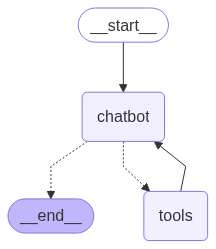

In [56]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node('chatbot', call_model)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue
)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

memory = MemorySaver()
config = {"configurable": {"thread_id": "abcde"}}

graph = graph_builder.compile(checkpointer = memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit", "quit", "q"]:
        print("Goodbye!")
        break

    # (1) invoke mode
    print('User\t:', user_input)
    response = graph.invoke({"messages": ("user", user_input)}, config=config)
    # print(response)
    # print(response["messages"])
    print('==========')
    print('AI\t:', response["messages"][-1].content)
    print('==========')
    
    # # (2) stream mode
    # print('User\t:', user_input)
    # print('==========')
    # print('AI\t:')
    # for chunk, _ in graph.stream({"messages": ("user", user_input)}, config=config, stream_mode="messages"):
    #     print(chunk.content, end="")
    # print('==========')

User	: 안녕? 나는 이용환이야.
AI	: 안녕하세요, 이용환님! 어떻게 도와드릴까요?
User	: 한국의 수도는 어디야?
AI	: 한국의 수도는 서울입니다. 서울은 한국의 정치, 경제, 문화의 중심지로 알려져 있습니다. 다른 질문이 있으신가요?
User	: 내 이름이 뭐지?
AI	: 당신의 이름은 이용환입니다. 다른 질문이 있으신가요?
User	: 서울 날씨 어때?
AI	: 서울의 날씨는 흐리고 기온은 섭씨 30도입니다. 다른 정보가 필요하신가요?
User	: 한국에서 가장 추운 도시는 어디야?
AI	: 한국에서 가장 추운 도시는 고성입니다. 다른 질문이 있으신가요?
User	: 고성 날씨는 어때?
AI	: 고성의 날씨는 맑고 기온은 섭씨 25도입니다. 추가로 궁금한 점이 있으신가요?
Goodbye!


In [ ]:
"가장 추운 도시의 날씨는 어때?"